# AI - Neural Networks

Name: `< علیرضا دهقانپور فراشاه >`

Student ID: `<98101555>`

## Install the requirements

In [130]:
!pip install -r requirements.txt

In [131]:
import numpy as np
import hw4_helper
import torch
from torch import nn


## Load train dataset
Note that the dataset will be downloaded in the `data_cache` directory for the first time. So do not remove that directory.

In [132]:
x_train, y_train = hw4_helper.get_train_data()
x_train.shape, y_train.shape

((98000, 28, 28), (98000,))

## Design your model

Write your neural network model below. Feel free to add extra cells.

In [135]:
class ConvolutionalNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.decider = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
    )
  

  def forward(self, x):
    res = self.layers(x)
    res = torch.flatten(res,1)
    res = self.decider(res)
    return res


## Train your Model
Write the training proecss below. Fell free to add extra cells

In [136]:
from torch.utils.data import DataLoader, TensorDataset

my_cnn = ConvolutionalNeuralNet()
device = torch.device('cuda')
my_cnn.to(device)
print(torch.cuda.is_available())
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(),lr=0.003)

dataset =TensorDataset(torch.unsqueeze(torch.Tensor(x_train),1),torch.Tensor(y_train))
train_subset, val_subset = torch.utils.data.random_split(
        dataset, [88000, 10000], generator=torch.Generator().manual_seed(1))

BATCH_SIZE = 100
NUMBER_OF_EPOCHS = 50
train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)





True


In [137]:
from statistics import mean
all_train_losses = []
all_train_accuracy = []
all_val_losses = []
all_val_accuracy = []
for epoch in range(NUMBER_OF_EPOCHS):
  # training
  epoch_loss = 0
  acc_list = []
  my_cnn.train()
  for i , (images , labels) in enumerate (train_loader):
    images , labels = images.to(device) , labels.to(device,dtype = torch.long)
    optimizer.zero_grad()
    outputs = my_cnn(images)
    loss = loss_function (outputs , labels)
    loss.backward()
    optimizer.step()
    # calculate accuracy
    epoch_loss += outputs.shape[0] * loss.item()
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    acc_list.append(correct/total)
  all_train_losses.append(epoch_loss/88000)
  print(epoch_loss/88000)
  all_train_accuracy.append(mean(acc_list))

  # evaluation on validation data
  loss_list = []
  my_cnn.eval() 
  with torch.no_grad():
    corr = 0
    tot = 0
    for j,(images , labels) in enumerate (val_loader):
      images , labels = images.to(device) , labels.to(device,dtype = torch.long)
      out = my_cnn(images)
      loss_list.append(loss_function (out , labels).item())
      predicts = torch.max(out.data,1)[1]
      tot += labels.size(0)
      corr += (predicts == labels).sum().item()
    all_val_accuracy.append(corr/tot)
    all_val_losses.append(mean(loss_list))
    print("validation accuracy : "+str((corr/tot)*100))

0.35093043366531756
validation accuracy : 94.55
0.16505063834219155
validation accuracy : 96.50999999999999
0.13235438203820113
validation accuracy : 96.38
0.11307187974135476
validation accuracy : 97.58
0.10018034120174972
validation accuracy : 97.50999999999999
0.0891908946626989
validation accuracy : 97.92
0.08304767879149454
validation accuracy : 97.83
0.07587911478000355
validation accuracy : 97.61
0.06768552386069628
validation accuracy : 98.02
0.06440513589027845
validation accuracy : 98.15
0.05887726349835496
validation accuracy : 97.66
0.05367232907843903
validation accuracy : 98.00999999999999
0.05003484196601097
validation accuracy : 97.97
0.048406936674093064
validation accuracy : 98.06
0.04537248220043363
validation accuracy : 98.22999999999999
0.040600271116868085
validation accuracy : 98.32
0.038628075179109475
validation accuracy : 98.14
0.036134881719176934
validation accuracy : 97.96000000000001
0.03666772141117359
validation accuracy : 98.4
0.0326965526196132
validat

## Draw the training curves
Draw two diagrams for train and validation, one showing loss of each epoch, and another showing accuracy of each epoch.

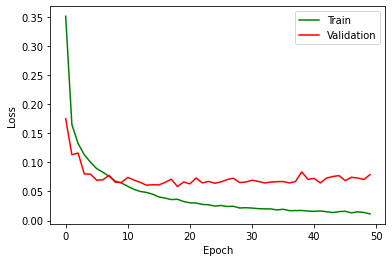

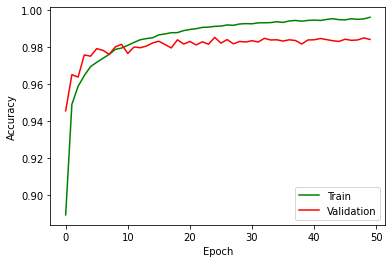

In [138]:
import matplotlib.pyplot as plt
plt.plot(all_train_losses,'green',label = 'Train')
plt.plot(all_val_losses,'red',label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.plot(all_train_accuracy,'green',label = 'Train')
plt.plot(all_val_accuracy,'red',label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Draw misclassified images
Draw 10 misclassified images from validation set with expected and predicted labels

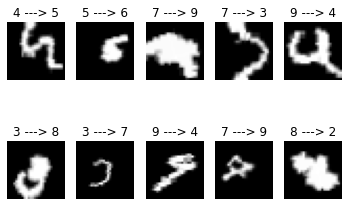

In [144]:
import random
mispredicted_samples = []
my_cnn.eval()
with torch.no_grad():
    for i,(images , labels) in enumerate (val_loader):
      images , labels = images.to(device) , labels.to(device,dtype = torch.long)
      out = my_cnn(images)
      predicts = torch.max(out.data,1)[1]
      wrong_idx = (predicts != labels.view_as(predicts)).nonzero()[:, 0]
      wrong_samples = images[wrong_idx]
      wrong_preds = predicts[wrong_idx]
      actual_preds = labels.view_as(predicts)[wrong_idx]
      for i in range(len(wrong_idx)):
          sample = wrong_samples[i]
          sample = sample.reshape([28,28])
          wrong_pred = wrong_preds[i]
          actual_pred = actual_preds[i]
          mispredicted_samples.append((sample.cpu(),actual_pred.cpu().item(),wrong_pred.cpu().item()))
figs , axes  = plt.subplots(nrows=2 , ncols=5)
index = 0
random_indexes = random.sample(range(0, len(mispredicted_samples)), 10)
plt.gray()
for ax in axes.flat:
  ax.set(title = str(mispredicted_samples[random_indexes[index]][1]) + " ---> "+ str(mispredicted_samples[random_indexes[index]][2]))
  ax.axis('off')
  ax.imshow(mispredicted_samples[random_indexes[index]][0])
  index += 1
      

## Evaluate your model on the test dataset

### Load test dataset
Note that the dataset will be downloaded for hte first time in the `data_cache` directory. So do not remove that directory.

In [145]:
x_test = hw4_helper.get_test_data()
x_test.shape

(21000, 28, 28)

### Run your model on test data

In [146]:
prediction = np.zeros(len(x_test))
my_cnn.eval()
with torch.no_grad():
  for i in range(len(x_test)):
    test = torch.unsqueeze(torch.unsqueeze(torch.Tensor(x_test[i]),0),0)
    test= test.to(device)
    result = my_cnn(test)
    result = torch.max(result.data,1)[1]
    prediction [i] = result
  print(prediction)


[3. 3. 7. ... 0. 7. 5.]


### Save the predictions
The following helper function will save the given prediction array (as a 1D numpy array) to `prediction.npy`. Upload this file with this notebook to quera as a `zip` file.

In [147]:
hw4_helper.export_prediction(prediction)

### Evaluate your predictions
The following helper function calls the test API with the given prediction array (as a 1D numpy array) and prints the server result.

In [149]:
hw4_helper.test(prediction)

Status: 200 - message: Your accuracy is 98.24%.
